In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.model_selection import  cross_validate, learning_curve, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score




df = pd.read_csv('index.csv')
df.insert(0, "Date", pd.to_datetime(df[["Year", "Month", "Day"]]))      # create datetime column
df.set_index(["Date"], inplace=True)                                    # set index to date, easy to handle 
df.drop(columns=["Year", "Month", "Day"], inplace=True)                 # deop redundant columns
df.drop(columns=["Federal Funds Target Rate", "Federal Funds Upper Target", "Federal Funds Lower Target"], inplace=True)        # these columns will not be used


targ_df = pd.DataFrame(df["Real GDP (Percent Change)"])     # create target and drop the NaNs to get to quarterly values


# determine date when inflation rate begins to ve recorded 
for i,j in enumerate(df["Inflation Rate"]):
    if not np.isnan(j):
        print(f"Inflation rates begin: {df.index[i]}")
        break        
 
df.drop(df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
df.drop(df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates
targ_df.drop(targ_df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
targ_df.drop(targ_df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates



# remove mid-month entries as these were wgen target rates were chanmged, theses only contain NaNs for our feqture vaeriables 
idx_mm = [i for i,j in enumerate(df.index.day) if j != 1]
df.drop(df.iloc[idx_mm].index, inplace=True) 
# same for targ df
idx_mm = [i for i,j in enumerate(targ_df.index.day) if j != 1]
targ_df.drop(targ_df.iloc[idx_mm].index, inplace=True) 




tss = TimeSeriesSplit(n_splits = 2)         # use time series train test split so we do not train on future data, 2 splits to increse cv sample size
for train_index, test_index in tss.split(df, targ_df):
    X_train, X_test = df.iloc[train_index, :].copy(), df.iloc[test_index,:].copy()
    y_train, y_test = targ_df.iloc[train_index].copy(), targ_df.iloc[test_index].copy()
X_train.drop(columns="Real GDP (Percent Change)", inplace=True)
X_test.drop(columns="Real GDP (Percent Change)", inplace=True)



lags = [1,2,3,4,5]        # introduce lag features 
cols = ["Effective Federal Funds Rate", "Inflation Rate", "Unemployment Rate"]  
# loop and dynamically name lags for train
for col in cols:
    for L in lags:
        X_train[f"{col} lag{L}"] = X_train[col].shift(L)
# same for test
for col in cols:
    for L in lags:
        X_test[f"{col} lag{L}"] = X_test[col].shift(L)

GDP_lags = targ_df.shift(1)

X_train.drop(X_train.iloc[0:5].index, inplace=True)
X_test.drop(X_test.iloc[0:5].index, inplace=True)


# Now need to reduce to quartely evaluation: 
y_train = y_train.loc["1958-08-01":"1997-03-01"]        # limits of X_train
y_train = y_train.dropna()                              # get rid of monthly values
X_train = X_train.loc[y_train.index]                    # use index of targ to change X
print(f"Check indices: {sum(y_train.index != X_train.index)}")                     # check


# same for test dataset
y_test = y_test.loc["1997-10-01":"2016-10-01"]
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]
print(f"check indices: {sum(y_train.index != X_train.index)}")

# create quarterly lags for GDP
gdp_lags = [1,2,3]
for L in gdp_lags:
    X_train[f"Real GDP (Percent Change) lag{L}"] = y_train["Real GDP (Percent Change)"].shift(L)

for L in gdp_lags:
    X_test[f"Real GDP (Percent Change) lag{L}"] = y_test["Real GDP (Percent Change)"].shift(L)

X_train.drop(X_train.iloc[0:3].index, inplace=True)
X_test.drop(X_test.iloc[0:3].index, inplace=True)
y_train.drop(X_train.iloc[0:3].index, inplace=True)
y_test.drop(X_test.iloc[0:3].index, inplace=True)



print(f'NaNs in X_train: {X_train[["Unemployment Rate", "Effective Federal Funds Rate", "Inflation Rate"]].isna().sum()}')       # check if all are removed
print(f'NaNs in y_train: {y_train["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed
print(f'NaNs in X_test: {X_test[["Unemployment Rate", "Effective Federal Funds Rate", "Inflation Rate"]].isna().sum()}')        # check if all are removed
print(f'NaNs in y_test: {y_test["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed
X_train.head(6)

Inflation rates begin: 1958-01-01 00:00:00
Check indices: 0
check indices: 0
NaNs in X_train: Unemployment Rate               0
Effective Federal Funds Rate    0
Inflation Rate                  0
dtype: int64
NaNs in y_train: 0
NaNs in X_test: Unemployment Rate               0
Effective Federal Funds Rate    0
Inflation Rate                  0
dtype: int64
NaNs in y_test: 0


,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate lag1,Effective Federal Funds Rate lag2,Effective Federal Funds Rate lag3,Effective Federal Funds Rate lag4,Effective Federal Funds Rate lag5,Inflation Rate lag1,Inflation Rate lag2,...,Inflation Rate lag4,Inflation Rate lag5,Unemployment Rate lag1,Unemployment Rate lag2,Unemployment Rate lag3,Unemployment Rate lag4,Unemployment Rate lag5,Real GDP (Percent Change) lag1,Real GDP (Percent Change) lag2,Real GDP (Percent Change) lag3
Date,,,,,,,,,,,,,,,,,,,,,
1959-07-01,3.47,5.1,2.0,3.39,2.90,2.96,2.80,2.43,2.0,2.0,...,1.7,1.7,5.0,5.1,5.2,5.6,5.9,10.1,7.7,9.7
1959-10-01,3.98,5.7,2.7,3.76,3.50,3.47,3.39,2.90,2.4,2.0,...,2.0,2.0,5.5,5.2,5.1,5.0,5.1,-0.8,10.1,7.7
1960-01-01,3.99,5.2,2.0,3.99,4.00,3.98,3.76,3.50,2.0,2.0,...,2.4,2.0,5.3,5.8,5.7,5.5,5.2,1.6,-0.8,10.1
1960-04-01,3.92,5.2,2.0,3.84,3.97,3.99,3.99,4.00,2.0,2.3,...,2.0,2.0,5.4,4.8,5.2,5.3,5.8,9.2,1.6,-0.8
1960-07-01,3.23,5.5,1.3,3.32,3.85,3.92,3.84,3.97,1.7,1.7,...,2.0,2.3,5.4,5.1,5.2,5.4,4.8,-1.5,9.2,1.6
1960-10-01,2.47,6.1,1.0,2.60,2.98,3.23,3.32,3.85,1.0,1.3,...,1.7,1.7,5.5,5.6,5.5,5.4,5.1,1.0,-1.5,9.2


In [12]:
abs(X_train.corrwith(y_train["Real GDP (Percent Change)"])).sort_values(ascending=False)

Effective Federal Funds Rate lag4    0.427075
Effective Federal Funds Rate lag5    0.417335
Effective Federal Funds Rate lag3    0.411639
Effective Federal Funds Rate lag2    0.374603
Effective Federal Funds Rate lag1    0.340545
Inflation Rate                       0.338071
Inflation Rate lag1                  0.335855
Inflation Rate lag2                  0.334910
Effective Federal Funds Rate         0.325568
Inflation Rate lag3                  0.318757
Inflation Rate lag4                  0.302891
Real GDP (Percent Change) lag1       0.287994
Inflation Rate lag5                  0.274062
Real GDP (Percent Change) lag2       0.216453
Unemployment Rate lag5               0.193678
Unemployment Rate lag4               0.167927
Unemployment Rate lag3               0.140050
Unemployment Rate lag2               0.108619
Unemployment Rate lag1               0.068909
Real GDP (Percent Change) lag3       0.053908
Unemployment Rate                    0.001200
dtype: float64

In [25]:
# Artificial Neural Network Pipeline

from sklearn.neighbors import KNeighborsRegressor
#import warnings
#from sklearn.exceptions import ConvergenceWarning
#warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Random seed
RNG = 42

reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor())
])


Best Parameters: {'model__n_neighbors': 19, 'model__p': 2, 'model__weights': 'uniform'}
Best CV R²: -0.165
NaNs entering model: 0
CV Mean R2 (train):  0.174 ± 0.101
CV Mean R2 (val):    -0.165  ± 0.405
CV Mean RMSE (val):  3.421
CV Mean MAE (val):   2.758
Test RMSE: 3.516 | Test MAE: 2.809 | Test R2: -1.027


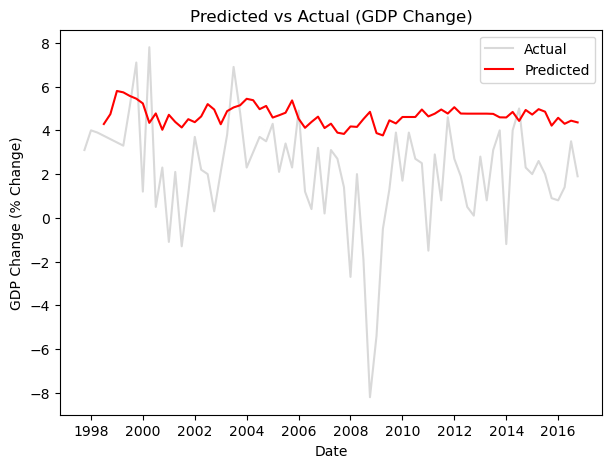

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call


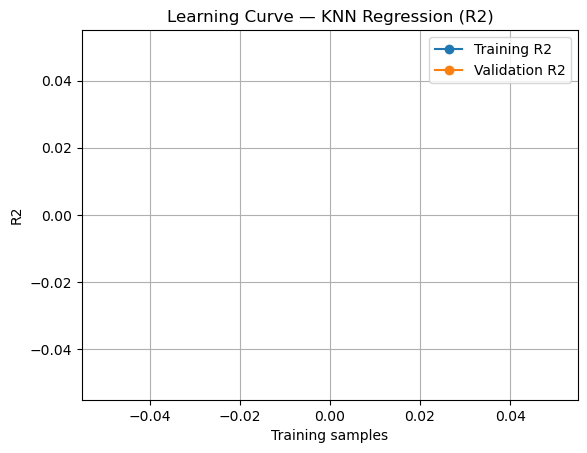

In [26]:
param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 25], # Number of nearest points used to predict target value, few, over, many, underfitting
    "model__weights": ["uniform", "distance"], # Uniform = all points contribute equally. Distance = weighted based on proximity 
    "model__p": [1, 2],  # 1=Manhattan, 2=Euclidean # Measure how similar two points are, using sum of differences (1) or line distance (2)
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    reg_pipe,
    param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=-1
)

# Flattening values to remove error
grid_search.fit(X_train, y_train.values.ravel())
#grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print(f"Best CV R²: {grid_search.best_score_:.3f}")

reg_pipe = grid_search.best_estimator_

# Check for NaNs entering prediction
X_check = reg_pipe[:-1].transform(X_test)
print("NaNs entering model:", np.isnan(X_check).sum())


# Run the test
y_pred = pd.Series(reg_pipe.predict(X_test), index=X_test.index)


# Run cross-validation
cv_reg = cross_validate(
    reg_pipe, X_train, y_train,
    cv=tscv, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True
)

# Display results
print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

# Calculate and print RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f} | Test MAE: {mae:.3f} | Test R2: {r2:.3f}")
#print(f"Train time: {train_time*1000:.1f} ms | Predict time: {pred_time*1000:.1f} ms")


# Create plot of predicted values
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(y_test.index, y_test, '-', color='0.85', label='Actual')
ax.plot(y_pred.index, y_pred, color='red', label='Predicted')
ax.set_ylabel('GDP Change (% Change)')
ax.set_xlabel('Date')
ax.set_title('Predicted vs Actual (GDP Change)')
ax.legend()
#plt.savefig("Predicted vs Actual (GDP Change)")
plt.show()


# Learning curve (KNN Regression, R2)
train_sizes, train_scores, val_scores = learning_curve(
    reg_pipe, X_train, y_train, cv=tscv, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 1), shuffle=True, random_state=RNG
)

# Print Learning Curve
plt.figure()
plt.title("Learning Curve — KNN Regression (R2)")
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R2")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation R2")
plt.xlabel("Training samples"); plt.ylabel("R2"); plt.legend(); plt.grid(True)
#plt.savefig("Learning Curve — KNN Regression (R2)")
plt.show()



